## Plotting mean X position of all worms against Chemotaxis Index

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
import pathlib as plb
from statistics import mean
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl

### Loading in the data
Data needed:
1. S1_ub_ia.csv: Unblinded image analysis data from Screen 1
2. A folder containing all .csv files with worm positions produced from the image analysis of S1 data

In [2]:
metadata = pd.read_csv('C:/Users/Emily/Documents/S1/data_analysis/S1_ub_ia.csv', index_col=0)
loc_path = plb.Path('C:/Users/Emily/Documents/S1/image_analysis/')

### Calculating the mean worm position from the worm location data

In [3]:
#Generating a function that will calculate mean worm position
def add_meanX(row):
    #Read in the location data
    fid = "loc_" + row['File Name'] + "_" + row['WellNo'] + ".csv"
    loc_dat = pd.read_csv(loc_path.joinpath(fid), index_col=0)
    #Calculate the mean x position
    loc_mean = int(mean(loc_dat['X']))
    return loc_mean

# Add the mean worm position to the metadata dataframe
metadata['Mean X']=metadata.apply(
    lambda row: add_meanX(row), axis=1)
    


### Creating numerical categories to visualize total worm counts

In [4]:
# Generating a callable function
def addSize(row):
    if row['Total Worms'] <= 150:
        size = 1
    elif (row['Total Worms']>150) & (row['Total Worms']<=250):
        size = 2
    elif (row['Total Worms']>250) & (row['Total Worms']<=350):
        size = 3
    elif (row['Total Worms']>350) & (row['Total Worms']<=450):
        size = 4
    elif row['Total Worms']>450:
        size = 5
    return size

#Iterating over the unblinded image analysis dataframe and adding categorical size data
metadata['Size']=metadata.apply(
    lambda row: addSize(row), axis=1)
metadata.head()

,WellNo,Total Worms,Chemotaxis,Compound,File Name,Well width,Plate ID,Mean X,Size
8,3A,229.0,-0.265957,5-Aminolevulinic acid (hydrochloride),S1_002,3058.0,S1_R1_7,1774,2
9,3B,275.0,-0.125541,Alyssin,S1_002,3065.0,S1_R1_7,1662,3
10,3C,231.0,-0.353535,Methyl palmitate,S1_002,3043.0,S1_R1_7,1803,2
11,3D,221.0,-0.255814,Safranal,S1_002,3075.0,S1_R1_7,1739,2
12,4A,270.0,-0.176991,Spinosad,S1_002,3051.0,S1_R1_8,1665,3


### Converting the location data from pixels to millimeters

In [5]:
# Images captured with 1200 dpi
# 1 inch = 25.4mm
mm = 25.4
# Pixels per mm
px_mm = 1200/mm

# Iterate over the dataframe to convert dpi to pixels per mm
metadata['Mean X mm']=metadata.apply(
    lambda row: ((-row['Mean X'])/px_mm)+32.5, axis=1)
#metadata.head()

### Calculating stats for the linear model to generate the residual plot

In [7]:
slope, intercept, r_value, p_value, std_err = stats.linregress(metadata['Mean X mm'], metadata['Chemotaxis'])
print(slope, intercept, r_value, p_value, std_err)

0.06060524841876873 -0.018946624031193293 0.9827857452463616 8.381452110101222e-212 0.0006736749168029377


In [8]:
print(f"R-squared: {r_value**2:.6f}")

R-squared: 0.965868


In [9]:
eq = np.poly1d(np.polyfit(metadata['Mean X mm'], metadata['Chemotaxis'], 1))
print(eq)

metadata['Predicted']=metadata.apply(
    lambda row: ((row['Mean X mm'])*.06061)-.01895, axis=1)

metadata['Residuals']=metadata.apply(
    lambda row: ((row['Chemotaxis'])-(row['Predicted'])), axis=1)

 
0.06061 x - 0.01895


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


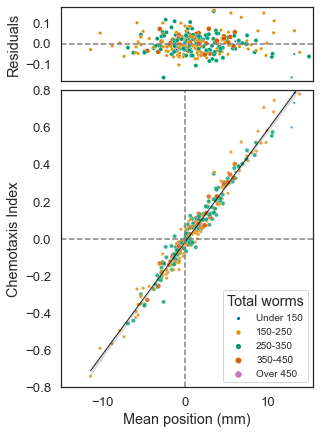

In [10]:


sb.set(font_scale=1.2, style='white')
gridkw = dict(height_ratios=[.25, 1])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gridkw, sharex=True, figsize=(5,7))

#Plotting the residual data within the inset axes
sb.scatterplot(x=metadata['Mean X mm'], y=metadata['Residuals'], hue=metadata['Size'], palette='colorblind',
               size=metadata['Size'], sizes=(5,30), ax=ax1, legend=False)

ax1.axhline(y=0, ls='--', c='gray')
ax1.set(xlim = (-15, 15.5))
ax1.set_ylabel('Residuals')
ax1.set_xlabel('')


# Scatterplot of Mean Position by X 
sb.scatterplot(metadata['Mean X mm'],metadata['Chemotaxis'], palette='colorblind',
      hue=metadata['Size'], alpha = .8, size=metadata['Size'], sizes=(5,30),ax=ax2, legend=True)
# Overlay the regression
sb.regplot(metadata['Mean X mm'], metadata['Chemotaxis'], scatter = False,
    fit_reg = True, color = 'black', line_kws={'linewidth':.75}, ax=ax2)

ax2.set(ylim = (-.8, .8)) 
ax2.set(xlim = (-15, 15.5))
ax2.axhline(y=0, ls='--', c='gray')
ax2.axvline(x=0, ls='--', c='gray')

ax2.set_xlabel('Mean position (mm)')
ax2.set_ylabel('Chemotaxis Index')

#Legend and legend aesthetics 
handles, labels  =  ax2.get_legend_handles_labels()
ax2.legend(handles, ['Under 150', '150-250', '250-350', '350-450', 'Over 450'], loc='lower right',
           title="Total worms", prop={'size': 10})

plt.rcParams['svg.fonttype'] = 'none'
fig.subplots_adjust(hspace=.05, left=.2)

#fig.savefig('D:/NP_manuscript/figs/stacked_CI_X.svg', dpi=300)

### The following is the first iteration of the plot for this data. Consider this version depricated

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Residuals')

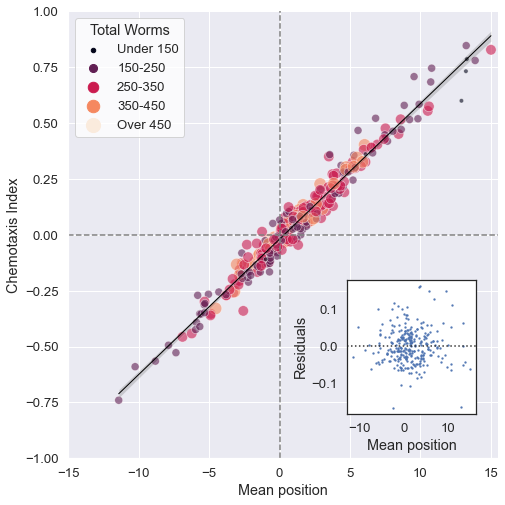

In [6]:

sb.set(font_scale=1.2, style='darkgrid')
p = sb.FacetGrid(metadata, size = 7, aspect = 1, sharex=True)

# Scatterplot of Mean Position by X 
p.map(sb.scatterplot, 'Mean X mm','Chemotaxis', palette='rocket',sizes=(20, 200),
      hue=metadata['Size'], alpha = .6, size=metadata['Size'], edgecolor='w')
# Overlay the regression
p.map(sb.regplot, 'Mean X mm', 'Chemotaxis', scatter = False,
    fit_reg = True, color = 'black', line_kws={'linewidth':1})

p.set(ylim = (-1, 1)) 
p.set(xlim = (-15, 15.5))
p.map(plt.axhline, y=0, ls='--', c='gray')
p.map(plt.axvline, x=0, ls='--', c='gray')

ax = plt.gca()
ax.set_xlabel('Mean position')
ax.set_ylabel('Chemotaxis Index')

#Resetting Seaborn style for inset
sb.set_style('white')

#Legend and legend aesthetics 
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Under 150', '150-250', '250-350', '350-450', 'Over 450'], loc='upper left', 
          title="Total Worms")

#Generating the inset axes
axins = p.ax.inset_axes([.65, .10, .3, .3])

#axins.set_facecolor('white')

#Plotting the residual data within the inset axes
sb.residplot( x='Mean X mm',y='Chemotaxis', data=metadata, scatter_kws={'s':2}, ax=axins )
axins.set_xlabel('Mean position')
axins.set_ylabel('Residuals')

# Saving the figure
#p.savefig('D:/NP_manuscript/figs/ciXx_reg.png')